In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from boplay.acq_funs.mes_utils import sample_yn1_ymax
from boplay.kernels import se_kernel
from boplay.gp import GaussianProcess

import seaborn as sns

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')



findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [2]:
np.random.seed(0)
import boplay

# the parent of the module
SAVE_DIR = Path(boplay.__file__).parent.parent / "paper_plots"
print(f"Pics will be saved to: {SAVE_DIR}")

Pics will be saved to: /lambda/nfs/nethome-us-west-1/lukehg/mes/paper_plots


# Generate Data to Plot

In [3]:


idx_train = np.array([0, 50, 90])

# Generate data to plot
n_yn1 = 41
n_ymax = 1000

# make a grid of x-values
x_grid = np.linspace(0, 100, 101).reshape(-1, 1)
n_x = x_grid.shape[0]

# make a train set of x-values and y-values
x_train = x_grid[idx_train, :]
y_train = np.asarray([0.5, 0.0, 1]).reshape(-1, 1)
y_best = float(max(y_train))

# make a kernel
kernel = partial(se_kernel, len_scale=10.0, sigma_f=1.0)

# make a Gaussian process
gp = GaussianProcess(x_train=x_train, y_train=y_train, kernel=kernel)

# get the mean and covariance of the Gaussian process
y_mean, y_cov = gp.predict(x_test=x_grid)

np.random.seed(0)
y_n1_samples, y_func_samples, y_max_samples, _ = sample_yn1_ymax(
    y_mean=y_mean,
    y_cov=y_cov,
    n_yn1=n_yn1,
    n_ymax=n_ymax,
)




/tmp/ipykernel_183458/60253447.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_best = float(max(y_train))


# Function to plot a GP and Samples Fucntions

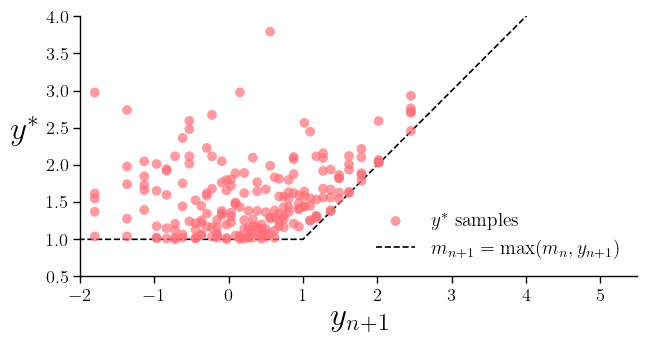

In [33]:
x_idx = 75
np.random.seed(0)

y_n1_samples_x_idx = y_n1_samples[x_idx, :, None]  # (n_yn1, 1)
y_n1_samples_x_idx = np.tile(y_n1_samples_x_idx, (1, n_ymax))  # (n_yn1, n_ymax)
y_max_samples_x_idx = y_max_samples[x_idx, :, :]  # (n_ymax, n_yn1)

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

y_max_label = r"$y^*$ samples"
for i in range(n_yn1):
    plot_idx = np.random.choice(n_ymax, replace=False, size=5)
    ax.scatter(
        y_n1_samples_x_idx[i, plot_idx],
        y_max_samples_x_idx[i, plot_idx],
        color="#FF6F79",
        alpha=0.7,
        linewidth=0,
        s=50,
        label=y_max_label,
        edgecolors='none',
    )
    y_max_label = None

ax.plot(
    [-100, y_best, 100], 
    [y_best, y_best, 100], 
    linestyle="--", 
    color="k",
    zorder=-1,
    # alpha=0.5,
    # label=r"$\displaystyle \max_{1 \le i \le n+1} y_i$",
    # label=r"$\max(y_1, \dots, y_{n+1})$",    
    # label=r"$\max(\{y\}_1^{n+1})$",
    # label="max(y_bar, y_n1)",
    label=r"$m_{n+1} = \max(m_n, y_{n+1})$",
)
ax.set_xlim(-2, 5.5)
ax.set_ylim(y_best - 0.5, 4)
ax.set_aspect("equal")
ax.set_xlabel(r"$y_{n+1}$", fontsize=24)
ax.set_ylabel(r"$y^*$", rotation=0, fontsize=24)

ax.legend(loc="lower right", frameon=False, fontsize=14)

ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)

sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(SAVE_DIR / "lhg_yn1_vs_ymax.pdf", bbox_inches="tight")